In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [2]:
# Step 1: Load datasets
# Penjelasan: Memuat dataset dari file Excel dengan dua sheet: DATA IK dan DATA IB
file_path = 'dataset.xlsx'  # Ubah ke lokasi file Anda
data_ik = pd.read_excel(file_path, sheet_name='DATA IK')
data_ib = pd.read_excel(file_path, sheet_name='DATA IB')

In [3]:
# Step 2: Preprocessing - Combine and clean data
# Penjelasan: Menggabungkan kolom tujuan dari DATA IK dan kolom desc dari DATA IB, lalu membersihkan data kosong.
data_ik = data_ik[['tujuan']].rename(columns={'tujuan': 'keperluan'})
data_ib = data_ib[['desc']].rename(columns={'desc': 'keperluan'})
data_combined = pd.concat([data_ik, data_ib], ignore_index=True)
data_combined.dropna(subset=['keperluan'], inplace=True)  # Menghapus nilai kosong


In [4]:
# Step 3: Clean text data
# Penjelasan: Membersihkan teks dari huruf besar, simbol, dan whitespace tambahan.
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Menghapus simbol dan angka
    text = re.sub(r"\s+", " ", text).strip()  # Menghapus whitespace berlebih
    return text

In [5]:
data_combined['keperluan'] = data_combined['keperluan'].apply(clean_text)

In [6]:
# Step 4: Categorize "keperluan"
# Penjelasan: Mengklasifikasikan teks berdasarkan pola yang relevan dengan kategori tertentu.
def classify_keperluan(text):
    if re.search(r"(laptop|printer|service|barang)", text):
        return "Memperbaiki Barang"
    elif re.search(r"(orangtua|keluarga|saudara|pulang|rumah|bertemu|libur)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek|PKM|tugas|makalah|observasi|akhir|data)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|sakit|berobat|obat)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(membeli|pribadi|mengurus|rekening|tabungan)", text):
        return "Urusan Pribadi"
    elif re.search(r"(exit|clearance|wisuda)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

In [7]:
data_combined['kategori'] = data_combined['keperluan'].apply(classify_keperluan)

In [8]:
# Step 5: TF-IDF Vectorization
# Penjelasan: Mengonversi teks menjadi fitur numerik menggunakan TF-IDF untuk analisis lebih lanjut.
factory = StopWordRemoverFactory()
stop_words_indonesian = factory.get_stop_words()

In [9]:
vectorizer = TfidfVectorizer(max_features=500, stop_words=stop_words_indonesian)
X = vectorizer.fit_transform(data_combined['keperluan']).toarray()
y = data_combined['kategori']

In [10]:
# Step 6: Train-Test Split
# Penjelasan: Membagi dataset menjadi data pelatihan dan pengujian untuk validasi model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Step 7: Train Decision Tree Model
# Penjelasan: Membuat model decision tree untuk klasifikasi.
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10, min_samples_split=20)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Classification Report:
                     precision    recall  f1-score   support

  Bertemu Keluarga       1.00      0.89      0.94     13205
           Lainnya       0.47      1.00      0.64      1927
Memperbaiki Barang       1.00      0.20      0.33       184
   Pergi ke Klinik       0.00      0.00      0.00       232
      Tamat Kuliah       1.00      0.87      0.93       248
      Tugas Kuliah       0.00      0.00      0.00       160
    Urusan Pribadi       0.00      0.00      0.00       118

          accuracy                           0.86     16074
         macro avg       0.50      0.42      0.41     16074
      weighted avg       0.90      0.86      0.87     16074



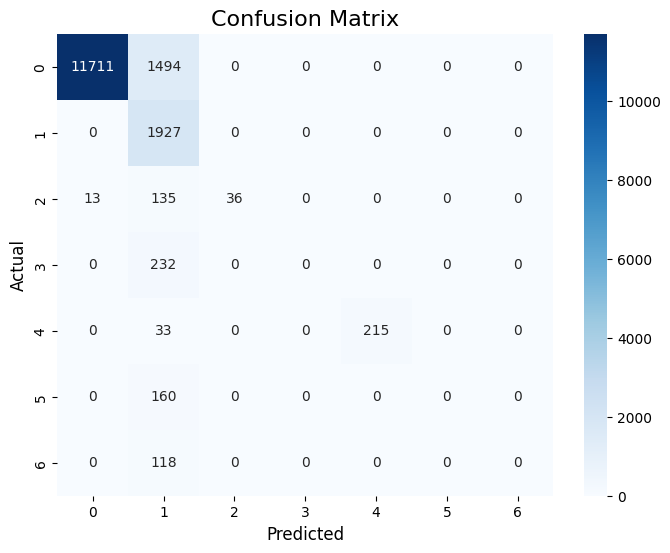

In [14]:
# Step 8: Evaluate Model
# Penjelasan: Mengevaluasi kinerja model dengan laporan klasifikasi dan matriks kebingungan.
y_pred = dt_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

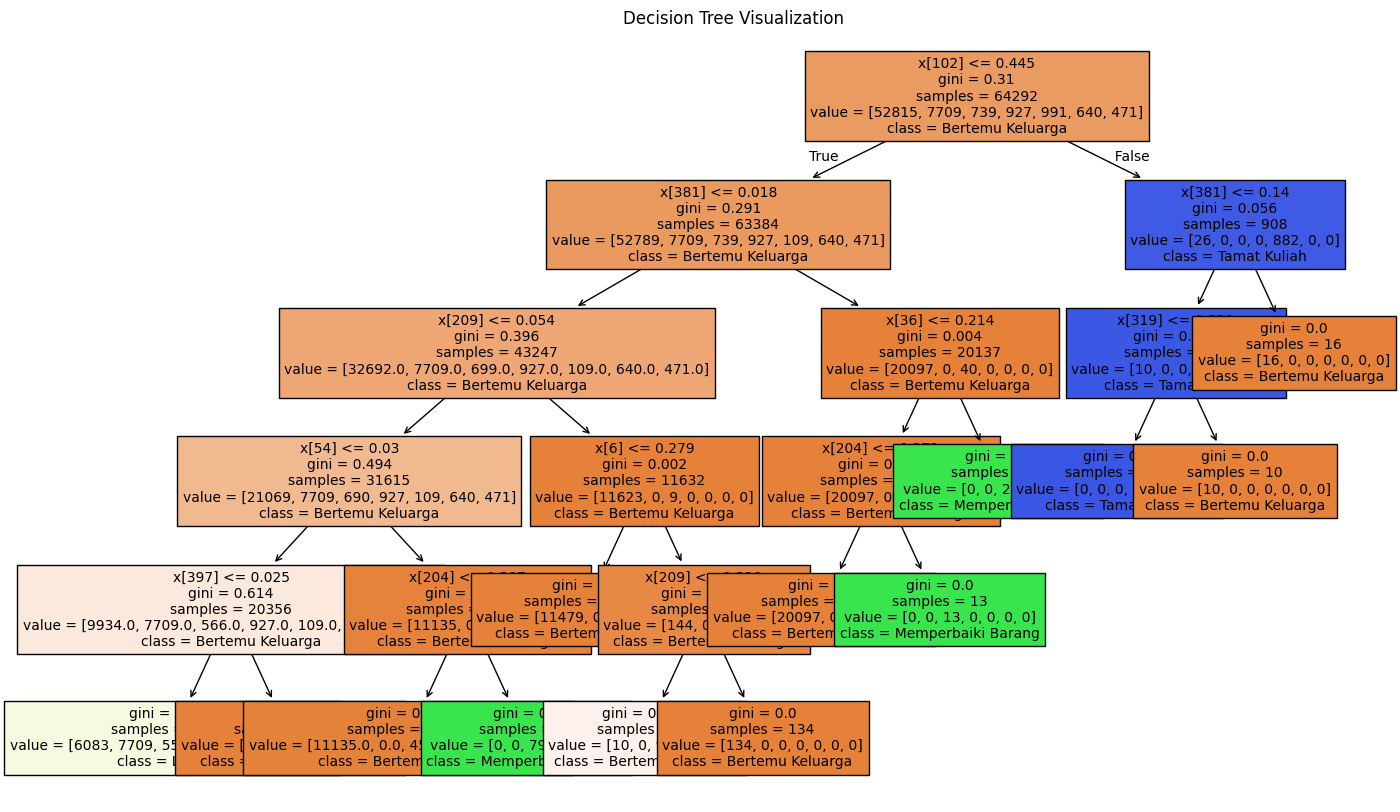

In [15]:
# Step 9: Visualize Decision Tree
# Penjelasan: Menampilkan struktur pohon keputusan.
plt.figure(figsize=(16, 10))
plot_tree(dt_model, class_names=dt_model.classes_, filled=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

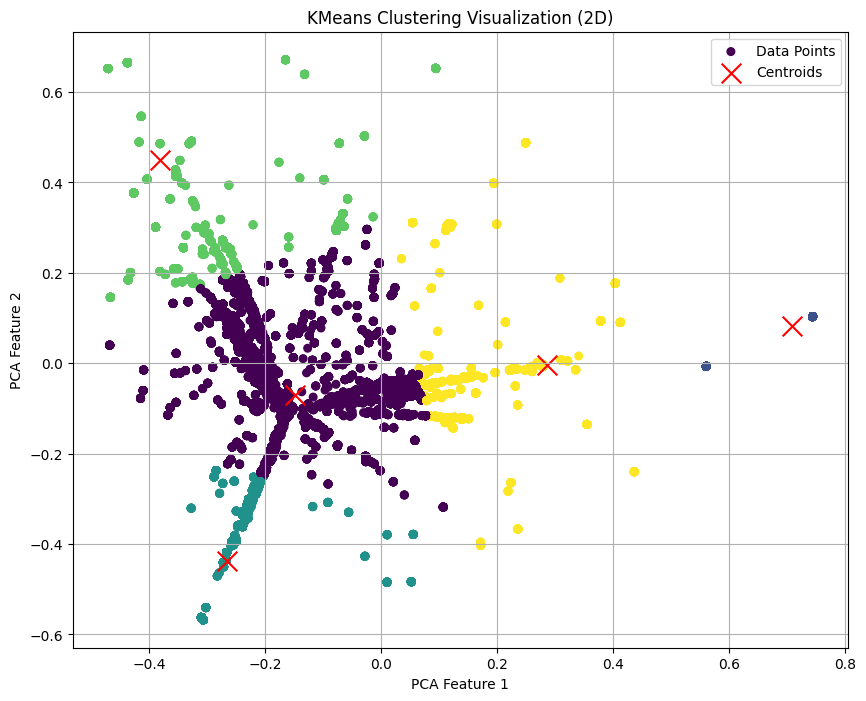

In [16]:
# Step 10: K-Means Clustering with PCA for Visualization
# Penjelasan: Melakukan clustering dengan K-Means dan memvisualisasikan hasilnya dalam 2 dimensi menggunakan PCA.
pca = PCA(n_components=2)  # Reduksi ke 2 dimensi
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20).fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', marker='o', s=30, label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title("KMeans Clustering Visualization (2D)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Export categorized data (optional)
# Penjelasan: Mengekspor data hasil klasifikasi ke file CSV.
data_combined.to_csv("categorized_keperluan.csv", index=False)
print("Data dengan kategori berhasil diekspor ke 'categorized_keperluan.csv'.")

Data dengan kategori berhasil diekspor ke 'categorized_keperluan.csv'.
